# <center>Curve Smoothing Algorithms</center>

### Random Datapoints

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate x values
x = np.linspace(0, 10, 200)

# True underlying function (e.g. smooth sine)
y_true = np.sin(x) + 0.5 * np.sin(3 * x)

# Add noise and spikes
np.random.seed(0)
noise = np.random.normal(0, 0.3, size=x.shape)
spikes = (np.random.rand(len(x)) > 0.95) * np.random.normal(2, 1, size=x.shape)
y_noisy = y_true + noise + spikes

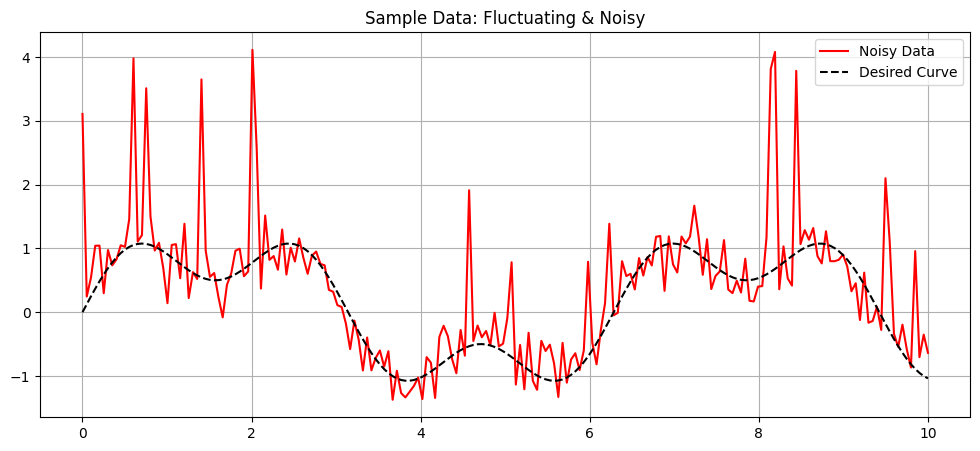

In [3]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(x, y_noisy, label='Noisy Data', color='red')
plt.plot(x, y_true, label='Desired Curve', color='black', linestyle='--')
plt.title("Sample Data: Fluctuating & Noisy")
plt.legend()
plt.grid(True)
plt.show()

**1.    Spline Interpolation**

In [4]:
import scipy
from scipy.interpolate import UnivariateSpline


spline = UnivariateSpline(x, y_noisy, s=30)  # s=0 means interpolation
y_pred = spline(x)


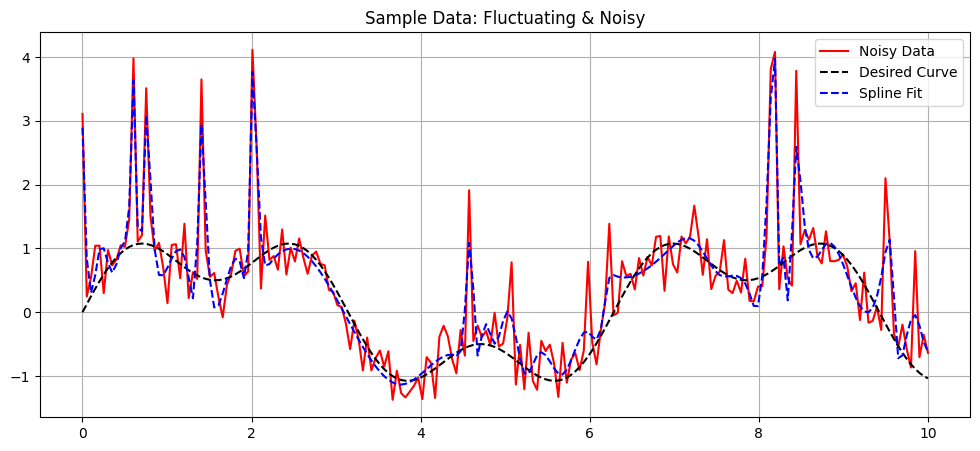

In [5]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(x, y_noisy, label='Noisy Data', color='red')
plt.plot(x, y_true, label='Desired Curve', color='black', linestyle='--')
plt.plot(x, y_pred, label='Spline Fit', color='blue', linestyle='--')
plt.title("Sample Data: Fluctuating & Noisy")
plt.legend()
plt.grid(True)
plt.show()

-   As we can see that spline interpolation performs well with higher number of **s** : smoothing factor.
-   However, in general, the algorithm performs poorly. It does not handle the outliers very well.

**2.    LOESs: Locally Estimated Scatterplot Smoothing**

-   With Loess algorithm, we apply weighted least square method for selected data points through a local neighbourhood.
-   Weights are sampled from **Tricube Weighting Function**

-   There are two modes of the algorithm
    1.  Fit a line inside the window: **Lowess**
    2.  Fit a parabula inside the window: **Loess**

-   In this case, we will use Loess method. (Quadratic polynomial)
-   Sliding window size represented as a proportion to the total datapoints
-   Performs better than Polynomial fitting

-   **Loess-v1** only considers the distance difference along the x axis
-   **Loess-v2** considers both x and y distance differences

In [12]:
def apply_weights(f_point, close_points):
    '''
    Apply weights to the current window of points.
    Formula: Tricube weighting function
    '''
    
    distances = np.abs(f_point - close_points)
    
    d = np.max(distances)
    if d == 0:
        return np.ones_like(distances)
    
    normalised = distances / d
    weights = (1 - normalised ** 3) ** 3
    weights[distances > 1] = 0
    return weights

def robust_weights(residuals):
    '''
    Apply robust weights to the residuals.
    Formula: Tukey's biweight function
    '''
    
    mad = np.median(np.abs(residuals - np.median(residuals)))
    if mad == 0:
        return np.ones_like(residuals).tolist()
    
    normalised = residuals /(6.0* mad)
    weights = (1 - normalised ** 2) ** 2
    weights[np.abs(normalised) >= 1] = 0
    return weights

def get_window(x, f_index, window_size):
    '''
    Get the closest neighbours of the current point.
    Distance is calculated as the absolute differnce between x values.
    '''
    distances = [(i,abs(xi - x[f_index])) for i, xi in enumerate(x)]

    closest_indeces = sorted(distances, key=lambda x: x[1])[:window_size]
    closest_indeces = [i for i, _ in closest_indeces]
    closest_indeces.sort()
    return [(i,x[i]) for i in closest_indeces]


def predict_point(f_point, x_window, y_window, window_size, weights):
    '''
    Fit a quadratic polynomial to the current window of points.
    return the predicted value for the current point by the polynomial.
    '''

    x = np.vstack([np.ones(window_size), x_window, x_window**2]).T

    #Apply weights
    w = np.diag(weights)

    #solve coefficients
    xtw = np.dot(x.T, w)
    xtwx = np.dot(xtw, x)
    xtwy = np.dot(xtw, y_window)

    #solve the system
    beta = np.linalg.solve(xtwx, xtwy)

    y_pred = beta[0] + beta[1] * f_point + beta[2] * f_point**2

    return y_pred

In [13]:
def loess(x, y, window=0.1):
    '''
    Apply LOESS smoothing to the data.
    return the smoothed y values.
    '''
    n = len(x)
    window_size = int(window * n)

    smoothed_y = []
    # Iterarte over each point in x
    for i, xp in enumerate(x):
        # get the window
        x_window_data = get_window(x, i, window_size)
        y_window = np.array([y[i] for i, _ in x_window_data])
        x_window = np.array([xi for _, xi in x_window_data])

        weights = apply_weights(xp, x_window)
        y_pred = predict_point(xp, x_window, y_window, window_size, weights)
        smoothed_y.append(y_pred)

    return smoothed_y

In [14]:
def loess_v2(x, y, window=0.1, iters=2):
    '''
    Apply LOESS smoothing to the data.
    return the smoothed y values.
    '''
    n = len(x)
    window_size = int(window * n)

    robust_w = np.ones(n)

    for _ in range(iters):
        smoothed_y = []

        # Iterarte over each point in x
        for i, xp in enumerate(x):

            # get the window
            x_window_data = get_window(x, i, window_size)
            y_window = np.array([y[i] for i, _ in x_window_data])
            x_window = np.array([xi for _, xi in x_window_data])
            index_window = [j for j, _ in x_window_data]

            x_weights = apply_weights(xp, x_window)
            combined_weights = np.array(x_weights) * robust_w[index_window]

            y_pred = predict_point(xp, x_window, y_window, window_size, combined_weights)
            smoothed_y.append(y_pred)

        smoothed_y = np.array(smoothed_y)

        if _ < iters - 1:
            residuals = y - smoothed_y
            robust_w = robust_weights(residuals)

    return smoothed_y

In [17]:
pred_y = loess(x, y_noisy, window=0.2)

In [18]:
pred_y2 = loess_v2(x, y_noisy, window=0.2, iters=3)

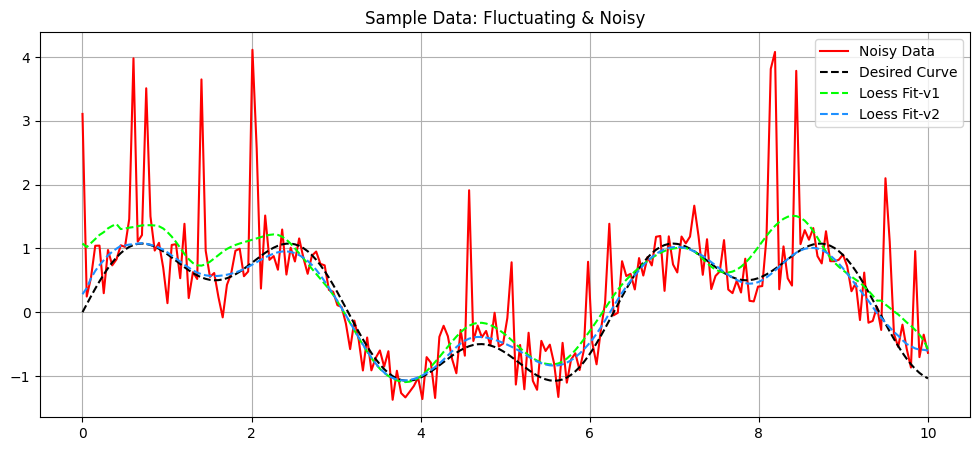

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(x, y_noisy, label='Noisy Data', color='red')
plt.plot(x, y_true, label='Desired Curve', color='black', linestyle='--')
plt.plot(x, pred_y, label='Loess Fit-v1', color='lime', linestyle='--')
plt.plot(x, pred_y2, label='Loess Fit-v2', color='dodgerblue', linestyle='--')
plt.title("Sample Data: Fluctuating & Noisy")
plt.legend()
plt.grid(True)
plt.show()

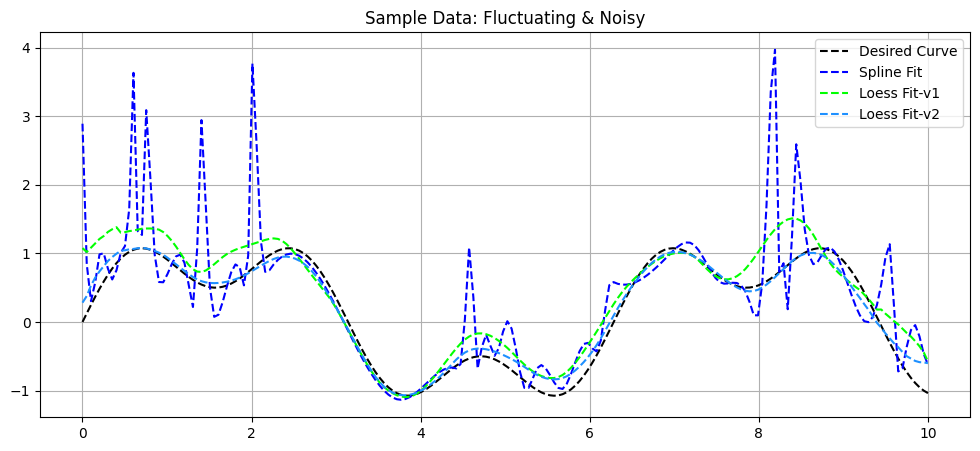

In [20]:
plt.figure(figsize=(12, 5))
#plt.plot(x, y_noisy, label='Noisy Data', color='red')
plt.plot(x, y_true, label='Desired Curve', color='black', linestyle='--')
plt.plot(x, y_pred, label='Spline Fit', color='blue', linestyle='--')
plt.plot(x, pred_y, label='Loess Fit-v1', color='lime', linestyle='--')
plt.plot(x, pred_y2, label='Loess Fit-v2', color='dodgerblue', linestyle='--')
plt.title("Sample Data: Fluctuating & Noisy")
plt.legend()
plt.grid(True)
plt.show()

-   As we can see that, Loess-v2 performs even better than v1. This due to the consideration of y distances differences
-   However, this is a visual comparison. Let's compare the performance with an evaluation metric

### <center>Comparing Curves</center>

In [21]:
def mean_absolute_error(y_true, y_pred):
    '''
    Calculate the Mean Absolute Error.
    '''
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    '''
    Calculate the Mean Squared Error.
    '''
    return np.mean((y_true - y_pred) ** 2)

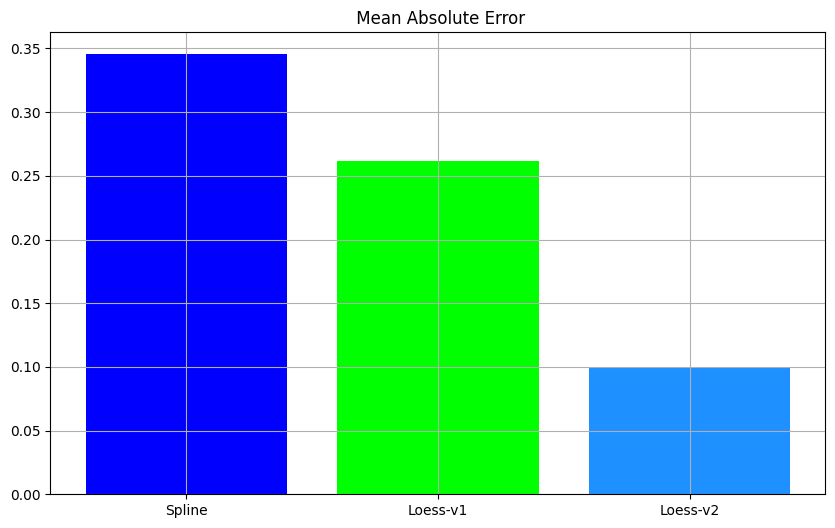

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(["Spline", "Loess-v1", "Loess-v2"], [mean_absolute_error(y_true, y_pred), mean_absolute_error(y_true, pred_y), mean_absolute_error(y_true, pred_y2)], color=['blue', 'lime', 'dodgerblue'])
plt.title(" Mean Absolute Error")
plt.grid(True)
plt.show()

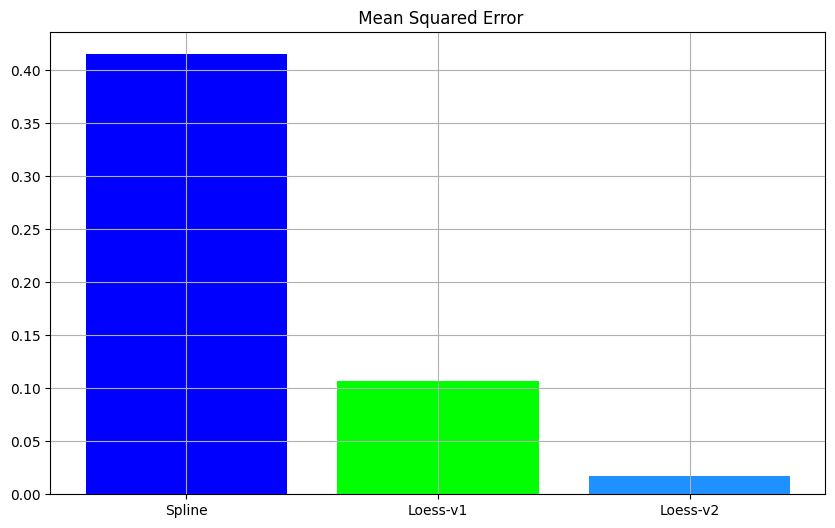

In [25]:
plt.figure(figsize=(10, 6))
plt.bar(["Spline", "Loess-v1", "Loess-v2"], [mean_squared_error(y_true, y_pred), mean_squared_error(y_true, pred_y), mean_squared_error(y_true, pred_y2)], color=['blue', 'lime', 'dodgerblue'])
plt.title(" Mean Squared Error")
plt.grid(True)
plt.show()